<a href="https://colab.research.google.com/github/Bishara10/ML-Classification-model-For-EEG-Recordings/blob/main/EEG_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Prerequisites


In [2]:
!git clone https://github.com/BPy5/ML-Classification-model-For-EEG-Recordings.git

Cloning into 'ML-Classification-model-For-EEG-Recordings'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 298 (delta 17), reused 2 (delta 0), pack-reused 256
Receiving objects: 100% (298/298), 72.74 MiB | 9.17 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Updating files: 100% (247/247), done.


In [3]:
import os
import numpy as np
import pandas as pd

from sklearn import datasets, svm
from sklearn.model_selection import train_test_split
import scipy.signal
from scipy.signal import resample, spectrogram, butter, filtfilt

import tensorflow as tf


%matplotlib notebook
%matplotlib inline


# Preprocess dataset

### Load Data

In [17]:
file_names_adhd_dataset = ['v8p.csv', 'v35p.csv', 'v37p.csv', 'v36p.csv', 'v38p.csv', 'v6p.csv', 'v40p.csv', 'v39p.csv', 'v3p.csv', 'v29p.csv', 'v30p.csv', 'v31p.csv', 'v28p.csv', 'v279.csv', 'v33p.csv', 'v25p.csv', 'v286.csv', 'v250.csv', 'v24p.csv', 'v246.csv', 'v263.csv', 'v27p.csv', 'v254.csv', 'v284.csv', 'v238.csv', 'v265.csv', 'v227.csv', 'v215.csv', 'v236.csv', 'v22p.csv', 'v21p.csv', 'v231.csv', 'v244.csv', 'v213.csv', 'v274.csv', 'v200.csv', 'v206.csv', 'v19p.csv', 'v173.csv', 'v270.csv', 'v234.csv', 'v179.csv', 'v181.csv', 'v18p.csv', 'v14p.csv', 'v196.csv', 'v209.csv', 'v183.csv', 'v12p.csv', 'v219.csv', 'v15p.csv', 'v20p.csv', 'v198.csv', 'v190.csv', 'v1p.csv', 'v32p.csv', 'v177.csv', 'v10p.csv', 'v34p.csv', 'v288.csv', 'v204.csv']
# print(len(file_names_adhd_dataset))
file_names_control_dataset = ['v51p.csv', 'v59p.csv', 'v304.csv', 'v45p.csv', 'v54p.csv', 'v58p.csv', 'v53p.csv', 'v60p.csv', 'v56p.csv', 'v46p.csv', 'v308.csv', 'v42p.csv', 'v43p.csv', 'v306.csv', 'v48p.csv', 'v50p.csv', 'v52p.csv', 'v302.csv', 'v44p.csv', 'v47p.csv', 'v307.csv', 'v57p.csv', 'v303.csv', 'v127.csv', 'v134.csv', 'v121.csv', 'v299.csv', 'v151.csv', 'v116.csv', 'v125.csv', 'v133.csv', 'v300.csv', 'v147.csv', 'v298.csv', 'v113.csv', 'v118.csv', 'v117.csv', 'v120.csv', 'v111.csv', 'v107.csv', 'v114.csv', 'v108.csv', 'v115.csv', 'v305.csv', 'v140.csv', 'v149.csv', 'v309.csv', 'v123.csv', 'v138.csv', 'v112.csv', 'v41p.csv', 'v129.csv', 'v143.csv', 'v310.csv', 'v131.csv', 'v297.csv', 'v109.csv', 'v49p.csv', 'v55p.csv', 'v110.csv']
# print(len(file_names_control_dataset))

pathControl = '/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/controlcsv/'
pathADHD = '/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/adhdcsv/'
outputPath = '/content/preprocessed_dataset/'

### Functions for preprocessing
Downsampling: to redude the number of samples in the given data.
BandPassFilter to filter signal noise.
Preprocess_file: preprocesses a single file.
Preprocess_group: preprocess and save all files to a corresponding group folder.

In [41]:
# Preprocessed dataset
dataADHD = []
dataControl = []

# parameters for bandpass filter
lowcut = 10.0
highcut = 40.0

# Set parameters for Spectrogram
original_fs = 128  # Sampling frequency in Hz
target_fs = 64  # Target sampling frequency in Hz
nperseg = 128  # Number of samples per segment
noverlap = 64  # Number of overlapping samples (typically half of nperseg)

In [20]:
# filter channel and reduce noise.
def bandPassFilter(signal):
    fs = 4000.0

    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    order = 2
    b, a = scipy.signal.butter(order, [low, high], 'bandpass', analog=False)
    y = scipy.signal.filtfilt(b, a, signal, axis=0)

    return y

In [21]:
# Function to downsample the signal
def downsample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    return resample(signal, num_samples)

In [37]:
# Preprocessing for an entire recording for a patient
def preprocess_file(input_file, group_category, max_time_bins):
  df = pd.read_csv(input_file)
  spectrograms = []

  for column in df.columns:
    #apply band pass filtering
    df[column] = bandPassFilter(df[column])

    #apply spectrogram to each channel after it was band-pass filtered
    t, f, spctg = spectrogram(df[column], fs=original_fs, nperseg=nperseg, noverlap=noverlap)

    spectrograms.append(spctg)

  spectrogram_stack = np.stack(spectrograms, axis=-1)
  if group_category == 'ADHD':
    dataADHD.append(spectrogram_stack)
  elif group_category == 'CONTROL':
    dataControl.append(spectrogram_stack)

  # df.to_csv(output_file, index=False)
  print(f"Spectrogram stack shape: {spectrogram_stack.shape}")

In [35]:
# Preprocess all recordings for a specific group
def preprocess_group(group_path, group_file_names, output_path, group_category, max_time_bins):
  for filename in group_file_names:
    file_name_and_path = group_path + filename;
    preprocess_file(file_name_and_path, group_category, max_time_bins)
  print("=============================== Preprocessing group successful =============================== ")

In [31]:
# Calculate the maximum time bins across all files
def calculate_max_time_bins(files):
    max_time_bins = 0
    for file in files:
        df = pd.read_csv(file)
        for column in df.columns:
            signal = df[column].values
            downsampled_signal = downsample_signal(signal, original_fs, target_fs)
            f, t, Sxx = spectrogram(downsampled_signal, fs=target_fs, nperseg=nperseg, noverlap=noverlap)
            max_time_bins = max(max_time_bins, Sxx.shape[1])
    return max_time_bins


In [42]:
filesADHD = ['/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/adhdcsv/' + x for x in file_names_adhd_dataset]
filesControl = ['/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/controlcsv/' + x for x in file_names_control_dataset]

# Find max time bin
x = calculate_max_time_bins(filesADHD)
y = calculate_max_time_bins(filesControl)
maxTimeBins = max(x, y)

# outputPath = '/content/preprocessed_dataset/'
# try:
#   os.mkdir(outputPath)
#   os.mkdir(outputPath + '/ADHD/')
#   os.mkdir(outputPath + '/Control/')
# except FileExistsError:
#   print("Folder Already exists.")

# preprocess groups
preprocess_group(pathADHD, file_names_adhd_dataset, outputPath + '/ADHD/', 'ADHD', maxTimeBins)
preprocess_group(pathControl, file_names_control_dataset, outputPath + '/Control/', 'CONTROL', maxTimeBins)


Spectrogram stack shape: (65, 245, 19)
Spectrogram stack shape: (65, 238, 19)
Spectrogram stack shape: (65, 144, 19)
Spectrogram stack shape: (65, 270, 19)
Spectrogram stack shape: (65, 384, 19)
Spectrogram stack shape: (65, 273, 19)
Spectrogram stack shape: (65, 313, 19)
Spectrogram stack shape: (65, 283, 19)
Spectrogram stack shape: (65, 523, 19)
Spectrogram stack shape: (65, 377, 19)
Spectrogram stack shape: (65, 337, 19)
Spectrogram stack shape: (65, 181, 19)
Spectrogram stack shape: (65, 430, 19)
Spectrogram stack shape: (65, 313, 19)
Spectrogram stack shape: (65, 455, 19)
Spectrogram stack shape: (65, 153, 19)
Spectrogram stack shape: (65, 178, 19)
Spectrogram stack shape: (65, 215, 19)
Spectrogram stack shape: (65, 255, 19)
Spectrogram stack shape: (65, 331, 19)
Spectrogram stack shape: (65, 290, 19)
Spectrogram stack shape: (65, 450, 19)
Spectrogram stack shape: (65, 162, 19)
Spectrogram stack shape: (65, 239, 19)
Spectrogram stack shape: (65, 152, 19)
Spectrogram stack shape: 

In [43]:
len(dataADHD)

61

In [44]:
len(dataControl)

60

In [46]:
maxTimeBins

336

In [ ]:
# # Just a checkup on a random file and its processed counterpart
# df = pd.read_csv(pathADHD + file_names_adhd_dataset[6])
# df2 = pd.read_csv(outputPath + '/ADHD/' + file_names_adhd_dataset[6])

# dfControl = pd.read_csv(pathControl + file_names_control_dataset[1])
# dfControl2 = pd.read_csv(outputPath + '/Control/' + file_names_control_dataset[1])

# fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 10))  # Adjust the figure size as necessary
# axes = axes.flatten()  # Flatten the 2D array of axes to simplify the iteration

# df['0'].plot(ax = axes[0])
# df2['0'].plot(ax = axes[1])

# dfControl['0'].plot(ax = axes[2])
# dfControl2['0'].plot(ax = axes[3])
# print(len(df['1']))

# Build CNN model

### Initialising the CNN

In [47]:
cnn = tf.keras.models.Sequential()

### Step 1 - Convolution

In [49]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(65, maxTimeBins, 19)))

### Step 2 - Pooling

In [50]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Adding a second convolutional layer

In [51]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Step 3 - Flattening

In [60]:
cnn.add(tf.keras.layers.Flatten())


### Step 4 - Full Connection

In [53]:
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

### Add hidden layer

In [59]:
cnn.add(Dense(64, activation='relu'))

### Step 5 - Output Layer

In [54]:
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

### Step 6 - Optimize

In [56]:
# Compile the model
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train / Test sets split

In [61]:
# Convert lists to numpy arrays
dataADHD = np.array(dataADHD)
dataControl = np.array(dataControl)

# Create labels
labelsADHD = np.ones(len(dataADHD))
labelsControl = np.zeros(len(dataControl))

# Combine data and labels
X = np.concatenate((dataADHD, dataControl), axis=0)
y = np.concatenate((labelsADHD, labelsControl), axis=0)

# Train the model
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
model.evaluate(X, y)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (61, 65) + inhomogeneous part.

# MISC


In [ ]:
# Read the CSV file as a NumPy array
x = pathADHD1
data = np.loadtxt(x, delimiter=',')

# Some `information about the channels
onedata = df['0'].values.tolist()

for i in range(0, len(onedata)):
  onedata[i] = str(onedata[i])
onedata.append('0')

ch_names = onedata # TODO: finish this list

# Sampling rate of the Nautilus machine
sfreq = 128  # Hz

# Create the info structure needed by MNE
info = mne.create_info(ch_names, sfreq)

# Finally, create the Raw object
raw = mne.io.RawArray(data, info)

# Plot it!
raw.plot()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
axes = axes.flatten()
df['2'].plot(kind='line', figsize=(8, 4), title='adhd', ax=axes[0])
df2['2'].plot(kind='line', figsize=(8, 4), title='control', ax=axes[1])
plt.gca().spines[['top', 'right']].set_visible(False)
# plt.xlim([0,3000])
plt.tight_layout()
plt.show()


# Root mean suqare energy

In [ ]:
#Root mean square energy
ndarray = df['0'].to_numpy()
RMS_music = librosa.feature.rms(y=ndarray, frame_length=128, hop_length=1)
RMS_music = RMS_music[0]
# RMS_music

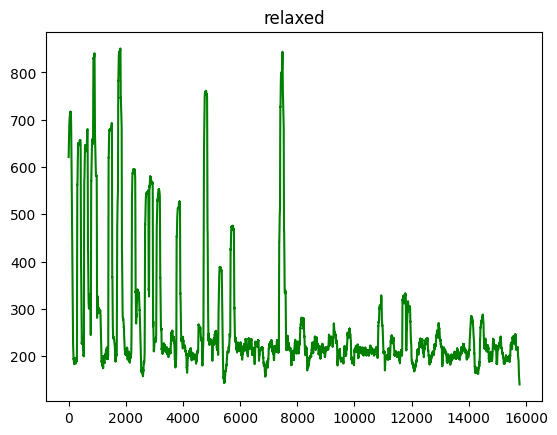

<Axes: >

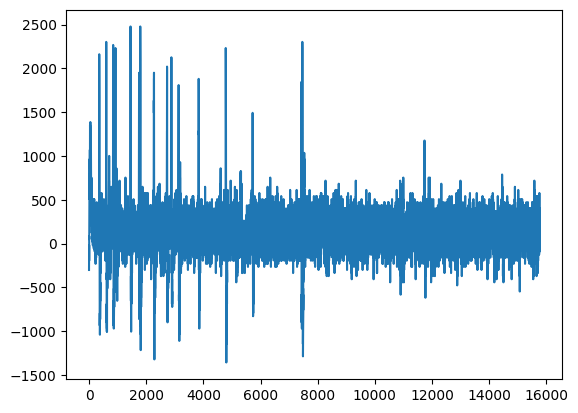

In [ ]:
frames = range(len(RMS_music))
plt.plot(frames, RMS_music, color='g')
plt.title('relaxed')
plt.show()
df['0'].plot()